In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

In [2]:
data = load_breast_cancer()
x_raw = data.data
y = data.target
feature_names = data.feature_names

# Z-score Normalization
mean = np.mean(x_raw, axis=0)
std = np.std(x_raw, axis=0)

# Avoid division by zero in case of constant features
std[std == 0] = 1.0

x_normalized = (x_raw - mean) / std

In [3]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.eigenvalues = None
        self.explained_variance_ratio = None

    def fit(self, x):
        # Mean centering
        self.mean = np.mean(x, axis=0)
        x_centered = x - self.mean

        # np.cov(x.T) expects rows as features, so we use transpose
        covariance_matrix = np.cov(x_centered.T)

        # Eigenvalue Decomposition
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

        # Sort eigenvalues and eigenvectors (descending)
        # Greater the eigenvalue the greater the variance captured
        indices = np.argsort(eigenvalues)[::-1]
        self.eigenvalues = eigenvalues[indices]
        sorted_eigenvectors = eigenvectors[:, indices]

        # Select top n_components
        self.components = sorted_eigenvectors[:, 0:self.n_components]

        # Calculate Explained Variance Ratio
        total_variance = np.sum(self.eigenvalues)
        self.explained_variance_ratio = (self.eigenvalues[:self.n_components] / total_variance)

        return self

    def transform(self, x):
        # Project data
        return np.dot(x - self.mean, self.components)

    def inverse_transform(self, x_transformed):
        return np.dot(x_transformed, self.components.T) + self.mean

    def calculate_reconstruction_error(self, x):
        x_transformed = self.transform(x)
        x_reconstructed = self.inverse_transform(x_transformed)
        mean_squarred_error = np.mean((x - x_reconstructed) ** 2)
        return mean_squarred_error

In [4]:
import numpy as np

class GMM:
    def __init__(self, n_components, covariance_type='full', convergence_threshold=1e-3, max_iter=100, regularized_covariance=1e-6):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.convergence_threshold = convergence_threshold
        self.max_iter = max_iter

        # Regularization to prevent singular matrices
        self.regularized_covariance = regularized_covariance

        # Parameters to be learned
        self.means = None
        self.covariances = None
        self.weights = None
        self.log_likelihood_history = []
        self.converged = False

    def _initialize_parameters(self, x):
        n_samples, n_features = x.shape

        # Initialize Weights (uniform)
        self.weights = np.full(self.n_components, 1 / self.n_components)

        # Initialize Means randomly
        indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = x[indices]

        # Initialize Covariances based on type
        if self.covariance_type == 'full':
            self.covariances = np.array([np.eye(n_features) for _ in range(self.n_components)])
        elif self.covariance_type == 'tied':
            self.covariances = np.eye(n_features)
        elif self.covariance_type == 'diagonal':
            self.covariances = np.ones((self.n_components, n_features))
        elif self.covariance_type == 'spherical':
            self.covariances = np.ones(self.n_components)

    def _estimate_gaussian_log_probability(self, x):
        n_samples, n_features = x.shape
        log_probabilities = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            mean = self.means[k]

            # Compute log-probability based on covariance type
            if self.covariance_type == 'full':
                # Add regularization to diagonal
                covariance_matrix = self.covariances[k] + np.eye(n_features) * self.regularized_covariance
                try:
                    # Cholesky decomposition for stable determinant and inverse
                    lower_triangular = np.linalg.cholesky(covariance_matrix)
                    log_determinant = 2 * np.sum(np.log(np.diag(lower_triangular)))
                    precision_matrix = np.linalg.inv(covariance_matrix)

                    difference = x - mean
                    # Mahalanobis distance calculation (x-mu) * inv(cov) * (x-mu)^T
                    temp = np.dot(difference, precision_matrix)
                    mahalanobis_distance = np.sum(temp * difference, axis=1)

                    log_probabilities[:, k] = -0.5 * (n_features * np.log(2 * np.pi) + log_determinant + mahalanobis_distance)
                except np.linalg.LinAlgError:
                    log_probabilities[:, k] = -np.inf # Handle singular matrix

            elif self.covariance_type == 'tied':
                covariance_matrix = self.covariances + np.eye(n_features) * self.regularized_covariance
                try:
                    lower_triangular = np.linalg.cholesky(covariance_matrix)
                    log_determinant = 2 * np.sum(np.log(np.diag(lower_triangular)))
                    precision_matrix = np.linalg.inv(covariance_matrix)

                    difference = x - mean
                    temp = np.dot(difference, precision_matrix)
                    mahalanobis_distance = np.sum(temp * difference, axis=1)

                    log_probabilities[:, k] = -0.5 * (n_features * np.log(2 * np.pi) + log_determinant + mahalanobis_distance)
                except np.linalg.LinAlgError:
                    log_probabilities[:, k] = -np.inf

            elif self.covariance_type == 'diagonal':
                covariance_vector = self.covariances[k] + self.regularized_covariance
                log_determinant = np.sum(np.log(covariance_vector))

                difference = x - mean
                mahalanobis_distance = np.sum((difference ** 2) / covariance_vector, axis=1)

                log_probabilities[:, k] = -0.5 * (n_features * np.log(2 * np.pi) + log_determinant + mahalanobis_distance)

            elif self.covariance_type == 'spherical':
                covariance_scalar = self.covariances[k] + self.regularized_covariance
                log_determinant = n_features * np.log(covariance_scalar)

                difference = x - mean
                mahalanobis_distance = np.sum((difference ** 2), axis=1) / covariance_scalar

                log_probabilities[:, k] = -0.5 * (n_features * np.log(2 * np.pi) + log_determinant + mahalanobis_distance)

        return log_probabilities

    def _e_step(self, x):
        # Calculate log probabilities: log(P(x|theta))
        log_probabilities = self._estimate_gaussian_log_probability(x)

        # Weighted log probabilities: log(w_k) + log(P(x|theta))
        weighted_log_probabilities = log_probabilities + np.log(self.weights + 1e-10)

        # Log-Sum-Exp trick for numerical stability
        max_weighted_log_prob = np.max(weighted_log_probabilities, axis=1, keepdims=True)

        # Use consistent variable name
        log_responsibilities = weighted_log_probabilities - max_weighted_log_prob
        log_responsibilities = log_responsibilities - np.log(np.sum(np.exp(log_responsibilities), axis=1, keepdims=True))

        # Responsibilities
        responsibilities = np.exp(log_responsibilities)
        return responsibilities, weighted_log_probabilities

    def _m_step(self, x, responsibilities):
        n_samples, n_features = x.shape
        weights_sum = np.sum(responsibilities, axis=0) # Nk

        # Update Weights
        self.weights = weights_sum / n_samples

        # Added 1e-10 to the denominator to prevent DivisionByZero errors if a cluster becomes empty (has 0 responsibilities) during training
        safe_weights_sum = weights_sum[:, np.newaxis] + 1e-10

        # Update Means
        self.means = np.dot(responsibilities.T, x) / safe_weights_sum

        # 3. Update Covariances
        if self.covariance_type == 'full':
            for k in range(self.n_components):
                difference = x - self.means[k]
                weighted_difference = responsibilities[:, k][:, np.newaxis] * difference
                self.covariances[k] = np.dot(weighted_difference.T, difference) / (weights_sum[k] + 1e-10)

        elif self.covariance_type == 'tied':
            average_covariance = np.zeros((n_features, n_features))
            for k in range(self.n_components):
                difference = x - self.means[k]
                weighted_difference = responsibilities[:, k][:, np.newaxis] * difference
                average_covariance += np.dot(weighted_difference.T, difference)
            self.covariances = average_covariance / n_samples

        elif self.covariance_type == 'diagonal':
            for k in range(self.n_components):
                difference = x - self.means[k]
                # Only keep diagonal elements (variance)
                self.covariances[k] = np.sum(responsibilities[:, k][:, np.newaxis] * (difference ** 2), axis=0) / (weights_sum[k] + 1e-10)

        elif self.covariance_type == 'spherical':
            for k in range(self.n_components):
                difference = x - self.means[k]
                # Average variance across all features
                variance = np.sum(responsibilities[:, k][:, np.newaxis] * (difference ** 2)) / (weights_sum[k] + 1e-10)
                self.covariances[k] = variance / n_features

    def fit(self, x):
        self._initialize_parameters(x)

        for i in range(self.max_iter):
            prev_log_likelihood = self.log_likelihood_history[-1] if self.log_likelihood_history else -np.inf

            # Expectation Step
            responsibilities, weighted_log_probabilities = self._e_step(x)

            # Maximization Step
            self._m_step(x, responsibilities)

            # Compute Log-Likelihood
            max_weighted_log_prob = np.max(weighted_log_probabilities, axis=1)
            sum_exponential = np.sum(np.exp(weighted_log_probabilities - max_weighted_log_prob[:, np.newaxis]), axis=1)
            log_likelihood = np.sum(max_weighted_log_prob + np.log(sum_exponential))

            self.log_likelihood_history.append(log_likelihood)

            # Convergence Check
            if abs(log_likelihood - prev_log_likelihood) < self.convergence_threshold:
                self.converged = True
                break

        return self

    def predict(self, x):
        responsibilities, _ = self._e_step(x)
        return np.argmax(responsibilities, axis=1)

    def bic(self, x):
        # Bayesian Information Criterion (Lower is better)
        n_samples, n_features = x.shape
        log_likelihood = self.log_likelihood_history[-1]

        # Count parameters based on covariance type
        if self.covariance_type == 'full':
            covariance_parameters = self.n_components * n_features * (n_features + 1) / 2
        elif self.covariance_type == 'tied':
            covariance_parameters = n_features * (n_features + 1) / 2
        elif self.covariance_type == 'diagonal':
            covariance_parameters = self.n_components * n_features
        elif self.covariance_type == 'spherical':
            covariance_parameters = self.n_components

        n_parameters = (self.n_components * n_features) + covariance_parameters + (self.n_components - 1)

        return -2 * log_likelihood + n_parameters * np.log(n_samples)

    def aic(self, x):
        # Akaike Information Criterion (Lower is better)
        n_samples, n_features = x.shape
        log_likelihood = self.log_likelihood_history[-1]

        # Calculate params
        if self.covariance_type == 'full':
            covariance_parameters = self.n_components * n_features * (n_features + 1) / 2
        elif self.covariance_type == 'tied':
            covariance_parameters = n_features * (n_features + 1) / 2
        elif self.covariance_type == 'diagonal':
            covariance_parameters = self.n_components * n_features
        elif self.covariance_type == 'spherical':
            covariance_parameters = self.n_components

        n_parameters = (self.n_components * n_features) + covariance_parameters + (self.n_components - 1)

        return -2 * log_likelihood + 2 * n_parameters

Model Converged: True
Final Log-Likelihood: 1579.77
BIC: 6273.81
AIC: -185.54


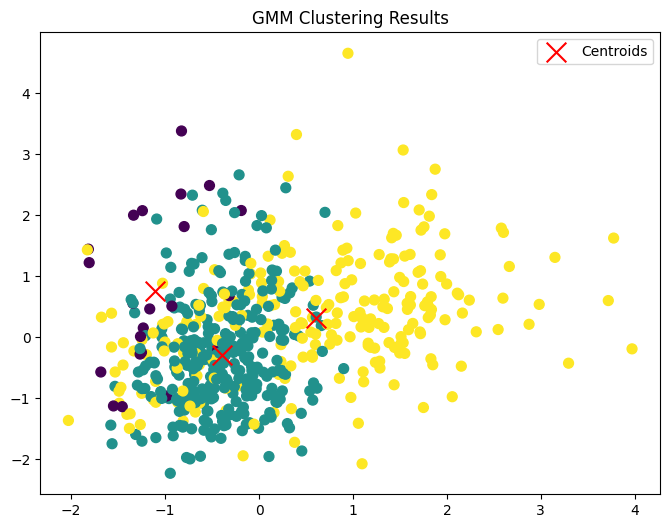

In [5]:
# Initialize GMM
model = GMM(n_components=3, covariance_type='full', max_iter=100)

# Train
model.fit(x_normalized)

# Predict
labels = model.predict(x_normalized)

# Evaluate
print(f"Model Converged: {model.converged}")
print(f"Final Log-Likelihood: {model.log_likelihood_history[-1]:.2f}")
print(f"BIC: {model.bic(x_normalized):.2f}")
print(f"AIC: {model.aic(x_normalized):.2f}")

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(x_normalized[:, 0], x_normalized[:, 1], c=labels, cmap='viridis', s=50)
plt.scatter(model.means[:, 0], model.means[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.title('GMM Clustering Results')
plt.legend()
plt.show()

GMM Hyperparameter Search...

Testing Covariance Type: full

Testing Covariance Type: tied

Testing Covariance Type: diagonal

Testing Covariance Type: spherical

Experiment Completed.


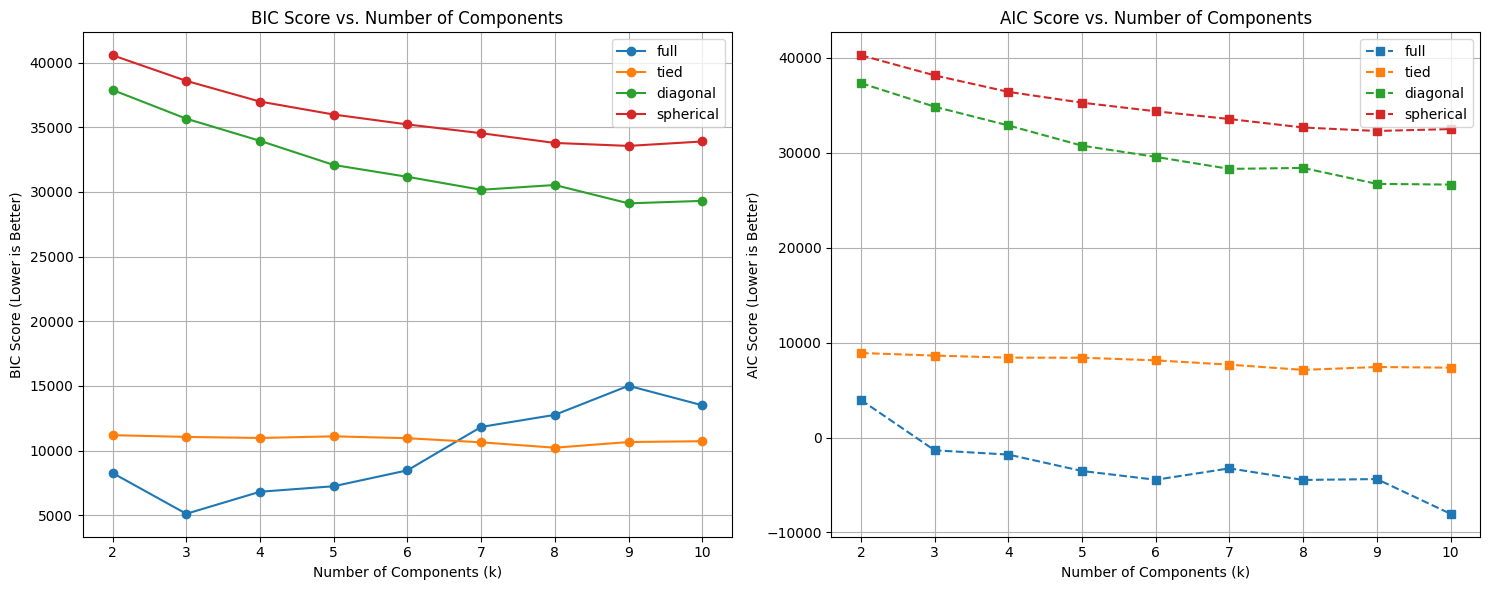

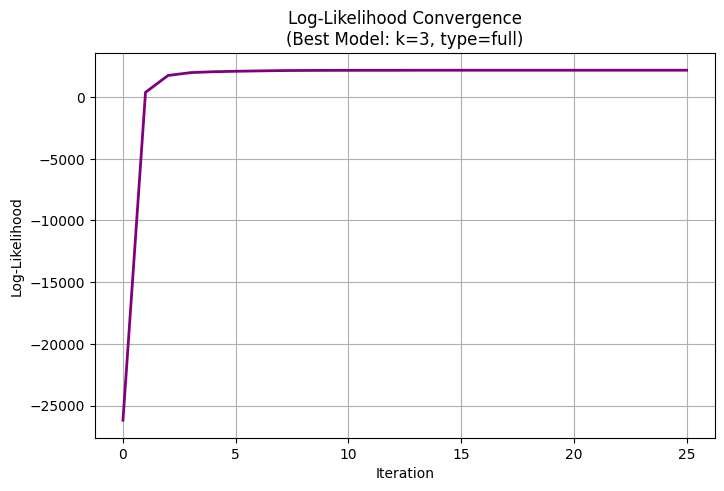

In [6]:
component_range = range(2, 11)  # Test k from 2 to 10
covariance_types = ['full', 'tied', 'diagonal', 'spherical']
results = []

print("GMM Hyperparameter Search...")

best_model = None
best_bic = np.inf

for cov_type in covariance_types:
    print(f"\nTesting Covariance Type: {cov_type}")

    for k in component_range:
        # Initialize and Train
        # regularization added to ensure stability
        gmm = GMM(n_components=k, covariance_type=cov_type, max_iter=100, regularized_covariance=1e-6)
        gmm.fit(x_normalized)

        # Collect Metrics
        curr_bic = gmm.bic(x_normalized)
        curr_aic = gmm.aic(x_normalized)
        final_ll = gmm.log_likelihood_history[-1]

        # Store result
        results.append({
            'k': k,
            'covariance_type': cov_type,
            'BIC': curr_bic,
            'AIC': curr_aic,
            'LogLikelihood': final_ll,
            'Converged': gmm.converged,
            'Iterations': len(gmm.log_likelihood_history)
        })

        # Track best model
        if curr_bic < best_bic:
            best_bic = curr_bic
            best_model = gmm

print("\nExperiment Completed.")
results_df = pd.DataFrame(results)

# BIC and AIC Curves
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for cov_type in covariance_types:
    subset = results_df[results_df['covariance_type'] == cov_type]

    # Plot BIC
    axes[0].plot(subset['k'], subset['BIC'], marker='o', label=f'{cov_type}')

    # Plot AIC
    axes[1].plot(subset['k'], subset['AIC'], marker='s', linestyle='--', label=f'{cov_type}')

axes[0].set_title('BIC Score vs. Number of Components')
axes[0].set_xlabel('Number of Components (k)')
axes[0].set_ylabel('BIC Score (Lower is Better)')
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('AIC Score vs. Number of Components')
axes[1].set_xlabel('Number of Components (k)')
axes[1].set_ylabel('AIC Score (Lower is Better)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Log-Likelihood Convergence for the Best Model
plt.figure(figsize=(8, 5))
plt.plot(best_model.log_likelihood_history, color='purple', linewidth=2)
plt.title(f'Log-Likelihood Convergence\n(Best Model: k={best_model.n_components}, type={best_model.covariance_type})')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.grid(True)
plt.show()